# Supercontinuum Example - All included

Author: Luis Ledezma (ledezma@caltech.edu)

## Single Envelope

Method from [1]. I plan to validate according to their second example, quoting:

""
""

[1]M. Conforti, F. Baronio, and C. De Angelis, “Nonlinear envelope equation for broadband optical pulses in quadratic media,” Phys. Rev. A, vol. 81, no. 5, p. 053841, May 2010, doi: 10.1103/PhysRevA.81.053841.

We begin by the typical Python imports.

In [1]:
%load_ext version_information

import numpy as np
from numpy.fft import fft, ifft, fftshift, fftfreq
import matplotlib.pyplot as plt
import time
from scipy import signal
from matplotlib import cm
import colorcet as cc
import pyfftw

#This are my libraries
import nlo 
import materials

plt.rcParams.update({'font.size': 18})

## Units
We'll work in SI units. Mostly in base units.

In [2]:
from scipy.constants import pi, c, epsilon_0
nm = 1e-9
um = 1e-6
mm = 1e-3
ps = 1e-12
fs = 1e-15
GHz = 1e9
THz = 1e12
pJ = 1e-12
mW = 1e-3

## Time and Frequency domain windows

Now we need to determine an FFT size $N$, this will be the common size for the time and frequency axis in our simulations. We also need to select how large the time window $T_{\mathrm{max}}$ for our simulations will be. The time window needs to be large enough so that no part of the pulse reaches the edge of the domain at any point. We will pick a reference group velocity for as the moving reference frame, so how much the pulse travels depends on the respective group velocity mismatches of all the frequency components with respect to this reference velocity.

The FFT poses the following relations between the time domain and frequency domain windows,
$$ T_\mathrm{max} = {N \Delta t} = \frac{1}{\Delta f }, \\
BW = f_s = \frac{1}{\Delta t},$$
or combining them
$$T_\mathrm{max} BW = N.$$

In [3]:
wl_ff = 1580*nm
f0_ff = c/wl_ff

#In this example we now what's the full bandwidth we want
f_max = c/(300*nm)
f_min = c/(10*um)
BW = f_max - f_min 

#Reference frequency
f_ref = (f_min + f_max)/2
wl_ref = c/f_ref
omega_ref = 2*pi*f_ref

#Time and frequency arrays
NFFT = 2**14

Tmax = NFFT/BW
dt = 1/BW
t_start = -1*ps

t_stop = t_start + NFFT*dt
t = np.arange(t_start, t_stop, step=dt)
f = fftfreq(NFFT, dt)
omega = 2*pi*f
df = f[1]-f[0]

#Absolute frequencies and wavelengths
f_abs = f + f_ref
wl_abs = c/f_abs
omega_abs = 2*pi*f_abs
f_min = np.amin(f_abs)
f_max = np.amax(f_abs)
wl_max = c/f_min
wl_min = c/f_max

print('Fundamental wavelength = %0.1f nm' %(wl_ff*1e9))
print('Fundamental frequency = %0.1f THz' %(f0_ff*1e-12))
print('Simulation bandwidth = %0.1f THz' %(BW*1e-12))
print('\n')
print('Reference wavelength = %0.1f nm' %(wl_ref*1e9))
print('Reference frequency = %0.1f THz' %(f_ref*1e-12))
print('\n')
print('Time window size = %0.3f ps' %(Tmax*1e12))
print('Sampling Rate = %0.3f fs' %(dt*1e15))
print('Frequency Resolution = %0.3f GHz' %(df*1e-9))
print('\n')
print('Minimum absolute frequency = %0.1f THz' %(f_min*1e-12))
print('Maximum absolute frequency = %0.1f THz' %(f_max*1e-12))
print('Minimum absolute wavelength = %0.1f nm' %(c/f_max*1e9))
print('Maximum absolute wavelength = %0.1f um' %(c/f_min*1e6))
print('\n')

#get the frequency indexes for fundamental and second harmonics
f0_ff_index = np.abs(f + f_ref - f0_ff).argmin()
print('Array index for fundamental = %i' %(f0_ff_index))

Fundamental wavelength = 1580.0 nm
Fundamental frequency = 189.7 THz
Simulation bandwidth = 969.3 THz


Reference wavelength = 582.5 nm
Reference frequency = 514.6 THz


Time window size = 16.902 ps
Sampling Rate = 1.032 fs
Frequency Resolution = 59.163 GHz


Minimum absolute frequency = 30.0 THz
Maximum absolute frequency = 999.2 THz
Minimum absolute wavelength = 300.0 nm
Maximum absolute wavelength = 10.0 um


Array index for fundamental = 10892


## Material properties

The higher order dispersion operator is
$$D = \beta(\Omega) - \beta_0(\Omega=0) - \beta_1(\Omega=0) \Omega$$.

Refractive index at fundamental = 2.129


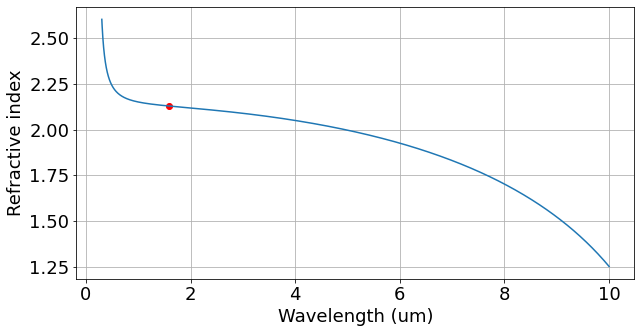

In [4]:
nLN = materials.refractive_index('LN_MgO_e', wl_abs*1e6)
nw = nLN[f0_ff_index]

plt.rcParams['figure.figsize'] = [10, 5]
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(fftshift(wl_abs*1e6), fftshift(nLN))
ax1.scatter(wl_abs[f0_ff_index]*1e6, nw, c='r')
# ax1.set_xlim([0.4,2])
# ax1.set_ylim([1.8,2.4])
ax1.set_xlabel('Wavelength (um)')
ax1.set_ylabel('Refractive index')
ax1.grid('on')

print('Refractive index at fundamental = %0.3f' %(nw))

GVD at 0.583 um = 307.148 fs^2/mm
GVD at 1.580 um = 88.009 fs^2/mm


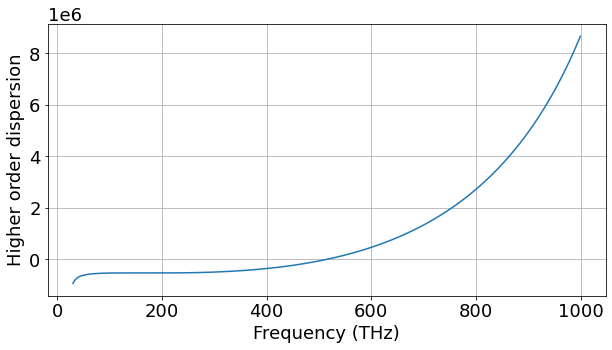

In [5]:
beta = (omega_abs)*nLN/c
beta_1 = np.gradient(beta, 2*pi*df)
beta_2 = np.gradient(beta_1, 2*pi*df)

beta_ref = beta[0]
beta_1_ref = beta_1[f0_ff_index]
D = beta - beta_ref - beta_1_ref*omega

plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(fftshift(f_abs)*1e-12, fftshift(D));
plt.xlabel('Frequency (THz)');
plt.grid(True)
plt.ylabel('Higher order dispersion');

print('GVD at %0.3f um = %0.3f fs^2/mm' %(wl_ref*1e6, beta_2[0]*1e27))
print('GVD at %0.3f um = %0.3f fs^2/mm' %(wl_ff*1e6, beta_2[f0_ff_index]*1e27))

## Input pulse creation

Pulse Energy = 2825.267 J
Pulse peak power = 56505341.138 GW


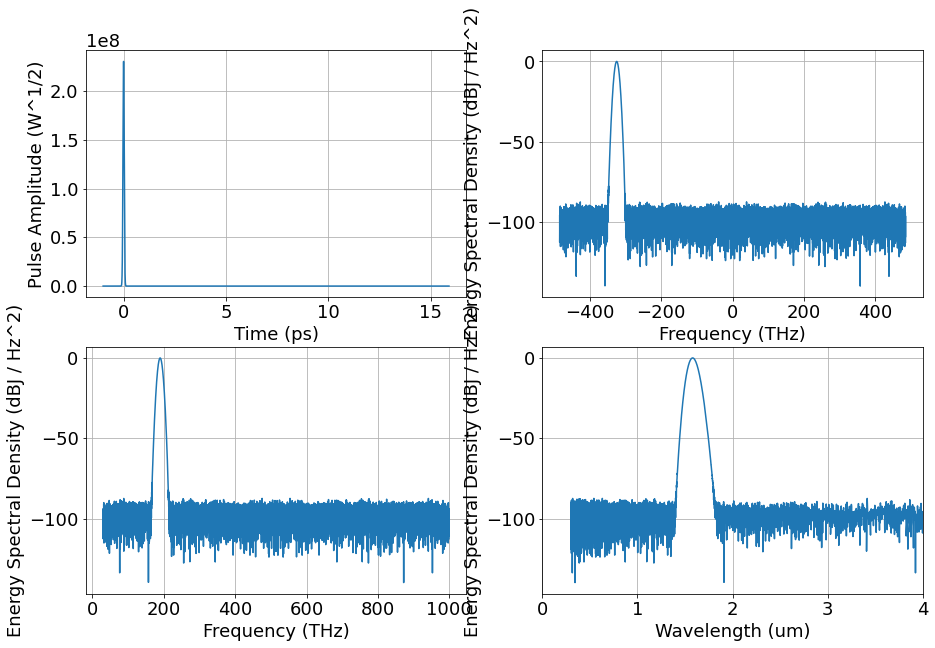

In [6]:
#Frequency offset from reference:
delta_omega = 2*pi*(f0_ff - f_ref)

#Peak value:
Intensity = 15e13 #15GW/cm^2
n = nLN[f0_ff_index]
Epeak = np.sqrt(2*Intensity/(n*c*epsilon_0))

#Pulse width:
tau = 50*fs

#Noise floor
noise = 2e3*np.random.normal(size=NFFT)

#Pulse creation
pulse = Epeak*np.exp(-2*np.log(2)*(t/tau)**2)*np.exp(1j*delta_omega*t)
pulse = pulse + noise
pulse_energy = nlo.energy_td(t, pulse) #To check that everything went well

print('Pulse Energy = %0.3f J' %(pulse_energy))
print('Pulse peak power = %0.3f GW' %(pulse_energy/tau*1e-9))

plt.rcParams['figure.figsize'] = [15, 10]
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

nlo.plot_mag(t, pulse, ax=ax1, t_unit='ps')
nlo.plot_ESD_dB(t, pulse, ax=ax2, f_unit = 'THz')
nlo.plot_ESD_dB_absfreq(t, pulse, f_ref, ax=ax3, f_unit = 'THz')
nlo.plot_ESD_dB_vs_wavelength(t, pulse, f_ref, ax=ax4, xlim=[0,4])

## Nonlinear  Stuff

In [7]:
def chi2(z):
    poling = np.sign(np.cos(z*2*pi/pp))
    return 2*d33*poling

def chi(z):
    return chi2(z)*(omega+omega_ref)/(4*nLN*c) #Freq dependent

In [8]:
def propagate(a, D):
    
    #Input data is in time domain
    a_evol = 1j*np.zeros([t.size, Nsteps+1])
    a_evol[:,0] = a #Initial value
    
    #Initialize the FFTW arrays
    a = pyfftw.empty_aligned(NFFT, dtype='complex128')
    A = pyfftw.empty_aligned(NFFT, dtype='complex128')
    aup = pyfftw.empty_aligned(Nup*NFFT, dtype='complex128')
    Aup = pyfftw.empty_aligned(Nup*NFFT, dtype='complex128')
    f1up = pyfftw.empty_aligned(Nup*NFFT, dtype='complex128')
    F1up = pyfftw.empty_aligned(Nup*NFFT, dtype='complex128')
    
    fft_a = pyfftw.FFTW(a, A)
    ifft_A = pyfftw.FFTW(A, a, direction='FFTW_BACKWARD')
    fft_f1up = pyfftw.FFTW(f1up, F1up)
    ifft_Aup = pyfftw.FFTW(Aup, aup, direction='FFTW_BACKWARD')
    
    #Frequency domain input
    a[:] = a_evol[:,0]
    A = fft_a()
    
    #Pre-compute some stuff:
    Dh = np.exp(-1j*D*h) #Dispersion operator for step size h
    tup = np.linspace(t[0], t[-1], Nup*NFFT) #upsampled time
    phi_1 = omega_ref*tup
    phi_2 = beta_ref - beta_1_ref*omega_ref
    F1 = np.zeros_like(A)
    
    #Upsampling stuff
    M = NFFT*Nup - A.size
    Xc = np.zeros(M)
    center = A.size // 2 + 1
    
    def fnl(z, A):
        phi = phi_1 - phi_2*z
        
        #Upsample
        Aup[:center] = A[:center]
        Aup[center:center+M] = Xc
        Aup[center+M:] = A[center:]
        aup[:] = ifft_Aup() * Nup
        
        #Nonlinear stuff
        xup = aup*(np.cos(phi) + 1j*np.sin(phi))
        f1up[:] = aup*(xup + 2*np.conj(xup))

        #Downsample
        F1up = fft_f1up()
        F1[:center] = F1up[:center]
        F1[center:] = F1up[center+M:]
        F1[:] = F1 / Nup

        return -1j*chi(z)*F1  
    
    tic = time.time()
    
    z = 0
    A[:] = A * np.exp(-1j*D*h/2) #Half step
    for kz in range(Nsteps):

        #Nonlinear step
        #Runge-Kutta 4th order
        k1 = fnl(z    , A       )
        k2 = fnl(z+h/2, A+h*k1/2)
        k3 = fnl(z+h/2, A+h*k2/2)
        k4 = fnl(z+h  , A+h*k3  )

        z = z + h
        A[:] = A + (h/6)*(k1+2*k2+2*k3+k4) 
        
        A[:] = A * Dh
        
        a = ifft_A()
        a_evol[:, kz+1] = a
        
        if abs(z%0.5e-3) < h:
            tdelta = time.time() - tic
            print('Completed propagation along %0.1f um (%0.1f s)' %((kz+1)*h*1e3, tdelta))
            tic = time.time()
            
    A[:] = A * np.exp(1j*D*h/2) #Final half dispersion step back
    a = ifft_A()
    return a, a_evol

In [32]:
Nup = 4

#Crystal parameters
pp = 30*um
L = 7*mm
# h = pp/10
# h = 1e-3/200
h = 1*um
Nsteps = int(L/h)+1
d33 = 27e-12

print('Crystal length = %0.2f mm' %(L*1e3))
print('Step size = %0.2f um' %(h*1e6))
print('Number of steps = %i' %(Nsteps))
print('Nonlinear coefficient, d33 = %0.2f pm/V' %(d33*1e12))
print('Using periodic poling with period = %0.3f um' %(pp*1e6))

Crystal length = 7.00 mm
Step size = 1.00 um
Number of steps = 7001
Nonlinear coefficient, d33 = 27.00 pm/V
Using periodic poling with period = 30.000 um


## Single pass

In [33]:
start_time = time.time()
[a, a_evol] = propagate(pulse, D)
stop_time = time.time()
print('Time elapsed = %0.1f s' %(stop_time - start_time))

Completed propagation along 0.5 um (14.5 s)
Completed propagation along 1.0 um (14.5 s)
Completed propagation along 1.5 um (14.7 s)
Completed propagation along 2.0 um (14.7 s)
Completed propagation along 2.5 um (14.5 s)
Completed propagation along 3.0 um (14.6 s)
Completed propagation along 3.5 um (14.7 s)
Completed propagation along 4.0 um (14.6 s)
Completed propagation along 4.5 um (14.6 s)
Completed propagation along 5.0 um (14.5 s)
Completed propagation along 5.5 um (14.7 s)
Completed propagation along 6.0 um (14.5 s)
Completed propagation along 6.5 um (14.7 s)
Completed propagation along 7.0 um (14.5 s)
Time elapsed = 205.4 s


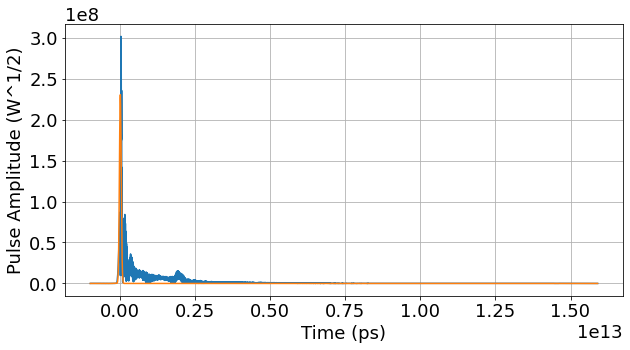

In [34]:
plt.rcParams['figure.figsize'] = [10, 5]
ax1 = nlo.plot_mag(t*1e12, a)
ax1 = nlo.plot_mag(t*1e12, pulse, ax=ax1)
# ax1.set_xlim(-2.5,0.5)
# ax1.set_ylim(0,3e8)

In [35]:
nlo.energy_td(t, pulse)

2825.267056912101

In [36]:
nlo.energy_td(t, a)

2847.1941354087107

In [37]:
# plt.rcParams['figure.figsize'] = [15, 5]
# X,Y = np.meshgrid(t*1e12, np.arange(Nsteps+1)*h*1e3)
# fig = plt.figure()
# ax = fig.add_subplot(111)
# im = ax.pcolormesh(X, Y, (np.transpose(np.abs(a_evol))), cmap = cc.cm["rainbow"])
# ax.set_xlabel('Time (ps)')
# ax.set_ylabel('Propagation distance (mm)')
# # ax.set_ylim([0,5])
# plt.colorbar(im, ax=ax)

## Spectrum

Text(0, 0.5, '')

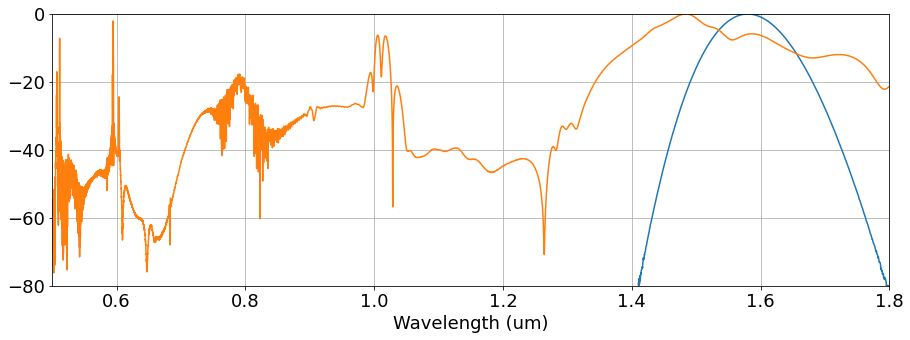

In [38]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax1 = fig.add_subplot(111)
nlo.plot_ESD_dB_vs_wavelength(t, pulse, f_ref, ax=ax1)
nlo.plot_ESD_dB_vs_wavelength(t, a, f_ref, ax=ax1)
ax1.set_xlim([0.5,1.8])
ax1.set_ylim([-80,0])
ax1.set_ylabel('')

Text(0, 0.5, '')

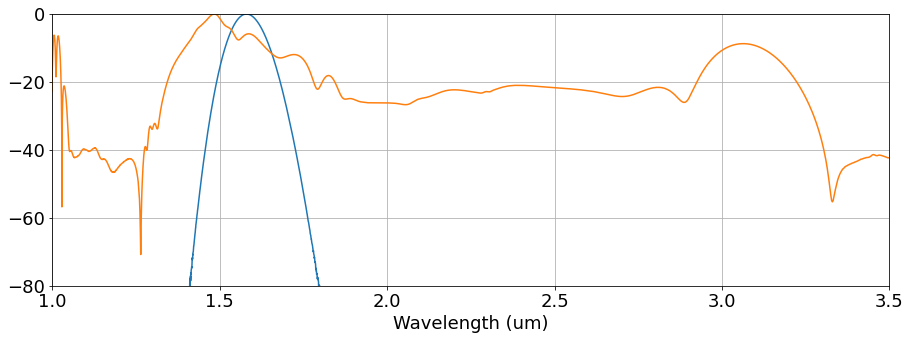

In [39]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax1 = fig.add_subplot(111)
nlo.plot_ESD_dB_vs_wavelength(t, pulse, f_ref, ax=ax1)
nlo.plot_ESD_dB_vs_wavelength(t, a, f_ref, ax=ax1)
ax1.set_xlim([1,3.5])
ax1.set_ylim([-80,0])
ax1.set_ylabel('')

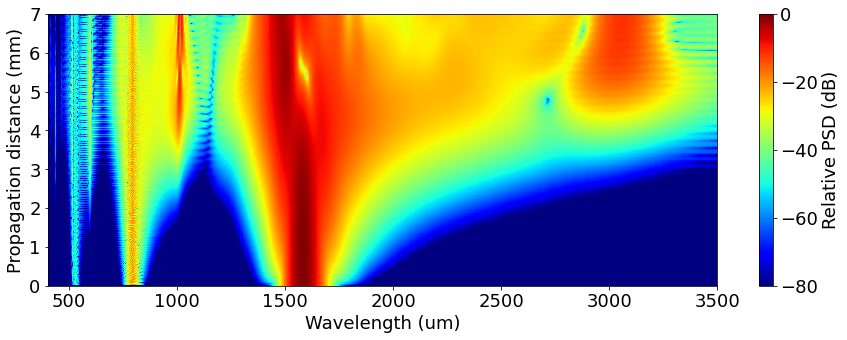

In [42]:
A_evol = np.zeros((t.size, Nsteps+1))

for k in range(Nsteps+1):
    x = a_evol[:,k]
    _ , Aesd = nlo.get_esd(t*1e15, x)
    A_evol[:,k] = 10*np.log10(Aesd)

A_evol = A_evol - np.amax(A_evol)
A_evol = fftshift(A_evol, axes=0)

plt.rcParams['figure.figsize'] = [15, 5]
Ndown = 20
wl_min = 0.4
wl_max = 3.5
wl_array = c/(fftshift(f)+f_ref)*1e6
wl_max_idx = np.abs(wl_array - wl_max).argmin()
wl_min_idx = np.abs(wl_array - wl_min).argmin()
wl_array = wl_array[wl_max_idx:wl_min_idx]*1e3
Xwl,Ywl = np.meshgrid(wl_array, np.arange(Nsteps+1)*h*1e3)
plt.figure()
plt.pcolormesh(Xwl[::Ndown,::], Ywl[::Ndown,::], (np.transpose(A_evol[wl_max_idx:wl_min_idx, ::Ndown])), cmap = cm.jet, vmin=-80, vmax=0)
cb = plt.colorbar()
cb.set_label('Relative PSD (dB)')
plt.xlabel('Wavelength (um)')
plt.ylabel('Propagation distance (mm)');

In [41]:
%version_information scipy, numpy, matplotlib

Software versions
Python 3.7.6 64bit [MSC v.1916 64 bit (AMD64)]
IPython 7.13.0
OS Windows 10 10.0.16299 SP0
scipy 1.4.1
numpy 1.18.1
matplotlib 3.2.1
Wed May 20 14:16:33 2020 Pacific Daylight Time